In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as to
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset

In [2]:
def secondval( value ):
    
    return value[0]

In [ ]:
class SiamDataset(Dataset):
    
    def __init__(self):
        
        data = list()
        
        img = pd.read_csv("/content/mnist_train.csv")
        img = img.values
        img = np.reshape(img, (-1, 28, 28))
        label = pd.read_csv("/content/trainMNISTlabels.csv").values
        
        # Get only 10% of the data
        img_len = int(len(img)*0.1)
        label_len = int(len(label)*0.1)
        img = img[:img_len]
        label = label[:label_len]
        
        print(label.shape,'train label')
        print(img.shape,'train label')
        for i in range(len(img)):
            # print(i)
            data.append( [ label[i], img[i] ] )
        
        data.sort(key = secondval)       
        self.len = len(img)        
        self.img = {}

        for i in data:           
            if i[0][0] not in self.img :
                self.img[i[0][0]] = list()
                self.img[i[0][0]].append(i[1])          
            else :
                self.img[i[0][0]].append(i[1])        
        pass
  
    def __getitem__(self, idx):
        
        clas = np.random.randint(0,10)            
        length = len(self.img[clas])
        im1, im2 = np.random.randint(0,length,2)            
        img1 = to.tensor(np.reshape(self.img[clas][im1],(1,28,28)), dtype=to.float32)
        img2 = to.tensor(np.reshape(self.img[clas][im2],(1,28,28)), dtype=to.float32)
        y1 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)                         
        len1 = len(self.img[clas])
        clas2 = ( clas + np.random.randint(0,9) ) % 9
        len2 = len(self.img[clas2])            
        im3 = np.random.randint(0,len1)
        im4 = np.random.randint(0,len2)           
        img3 = to.tensor(np.reshape(self.img[clas][im3],(1,28,28)), dtype=to.float32)
        img4 = to.tensor(np.reshape(self.img[clas2][im4],(1,28,28)), dtype=to.float32)
        y2 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)            
        return  img1, img2, y1, img3, img4, y2
            
    def __len__(self):
            
        return 10000

In [ ]:
class Siamese(nn.Module):
    
    def __init__(self):
        super(Siamese,self).__init__()
        
        # A simple two layer convolution followed by three fully connected layers should do
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d( kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d( kernel_size=3)
        
        self.lin1 = nn.Linear(144, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 10)
        
    def forward_once(self,x):
          
        out = self.pool1(nn.functional.relu(self.conv1(x)))
        out = self.pool2(nn.functional.relu(self.conv2(out)))        
        out = out.view(-1,144)        
        out = nn.functional.relu(self.lin1(out))
        out = nn.functional.relu(self.lin2(out))
        out = self.lin3(out)        
        return out
    
    def forward(self, x, y):                 
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)        
        return out1, out2
       
    def evaluate(self, x, y):       
        m = to.tensor(1.0, dtype=to.float32)        
        if type(m) != type(x):
            x = to.tensor(x, dtype = to.float32, requires_grad = False)            
        if type(m) != type(y):
            y = to.tensor(y, dtype = to.float32, requires_grad = False)        
        x = x.view(-1,1,28,28)
        y = y.view(-1,1,28,28)       
        with to.no_grad():           
            out1, out2 = self.forward(x, y)           
            return nn.functional.pairwise_distance(out1, out2)

In [5]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):       
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)      
        loss_contrastive = to.mean((1-label) * to.pow(euclidean_distance, 2) +
                                      (label) * to.pow(to.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [7]:
siamdset = SiamDataset()
train_dataloader = DataLoader(siamdset, shuffle=True, batch_size= 16,
                        num_workers=8)
siam = Siamese()

(5999, 1) train label
(5999, 28, 28) train label


In [8]:

number_epochs = 300
Criterion = ContrastiveLoss()
Optimizer = to.optim.Adam(siam.parameters(),lr = 0.001 )

In [9]:
counter = []
loss_history = [] 
iteration_number= 0

In [10]:
print("Initiating Training")
print("Calculating Training loss...")
for epoch in range(0,number_epochs):

    for data in train_dataloader:
   
        img1, img2 , label1, img3, img4, label2 = data
    
        Optimizer.zero_grad()
        
        # here we obtain the positive pairs' loss as well as the negative pairs' loss
        
        output1,output2 = siam(img1,img2)
        output3,output4 = siam(img3,img4)
        
        loss_pos = Criterion(output1,output2,label1)
        loss_neg = Criterion(output3,output4,label2)
        
        # the total loss is then computed and back propagated
        
        loss_contrastive = loss_pos + loss_neg
        
        loss_contrastive.backward()
        
        Optimizer.step()
    
    # # printing the training errors
    
    # print("Epoch number {}\n  Current loss {}\n".format(epoch,loss_contrastive.item()))
    # counter.append(epoch+100)
    # loss_history.append(loss_contrastive.item())

print(f"Training Finished with {number_epochs} Epochs")

In [11]:
plt.plot(counter,loss_history)
plt.savefig("/content/Siamese-network-on-MNIST-PyTorch/Siamese/plot/Siamese_loss.png")

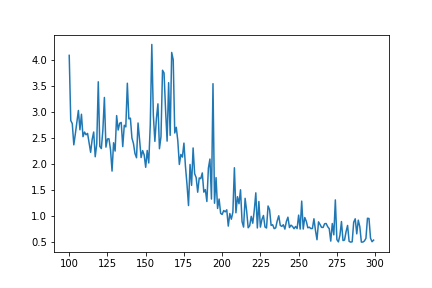

In [12]:
to.save(siam.state_dict(), "/content/Siamese-network-on-MNIST-PyTorch/Siamese/Siamese model")

In [13]:
%matplotlib inline

In [14]:
trial = list()

for i in range(0,5):
    trial.append(siamdset[i])

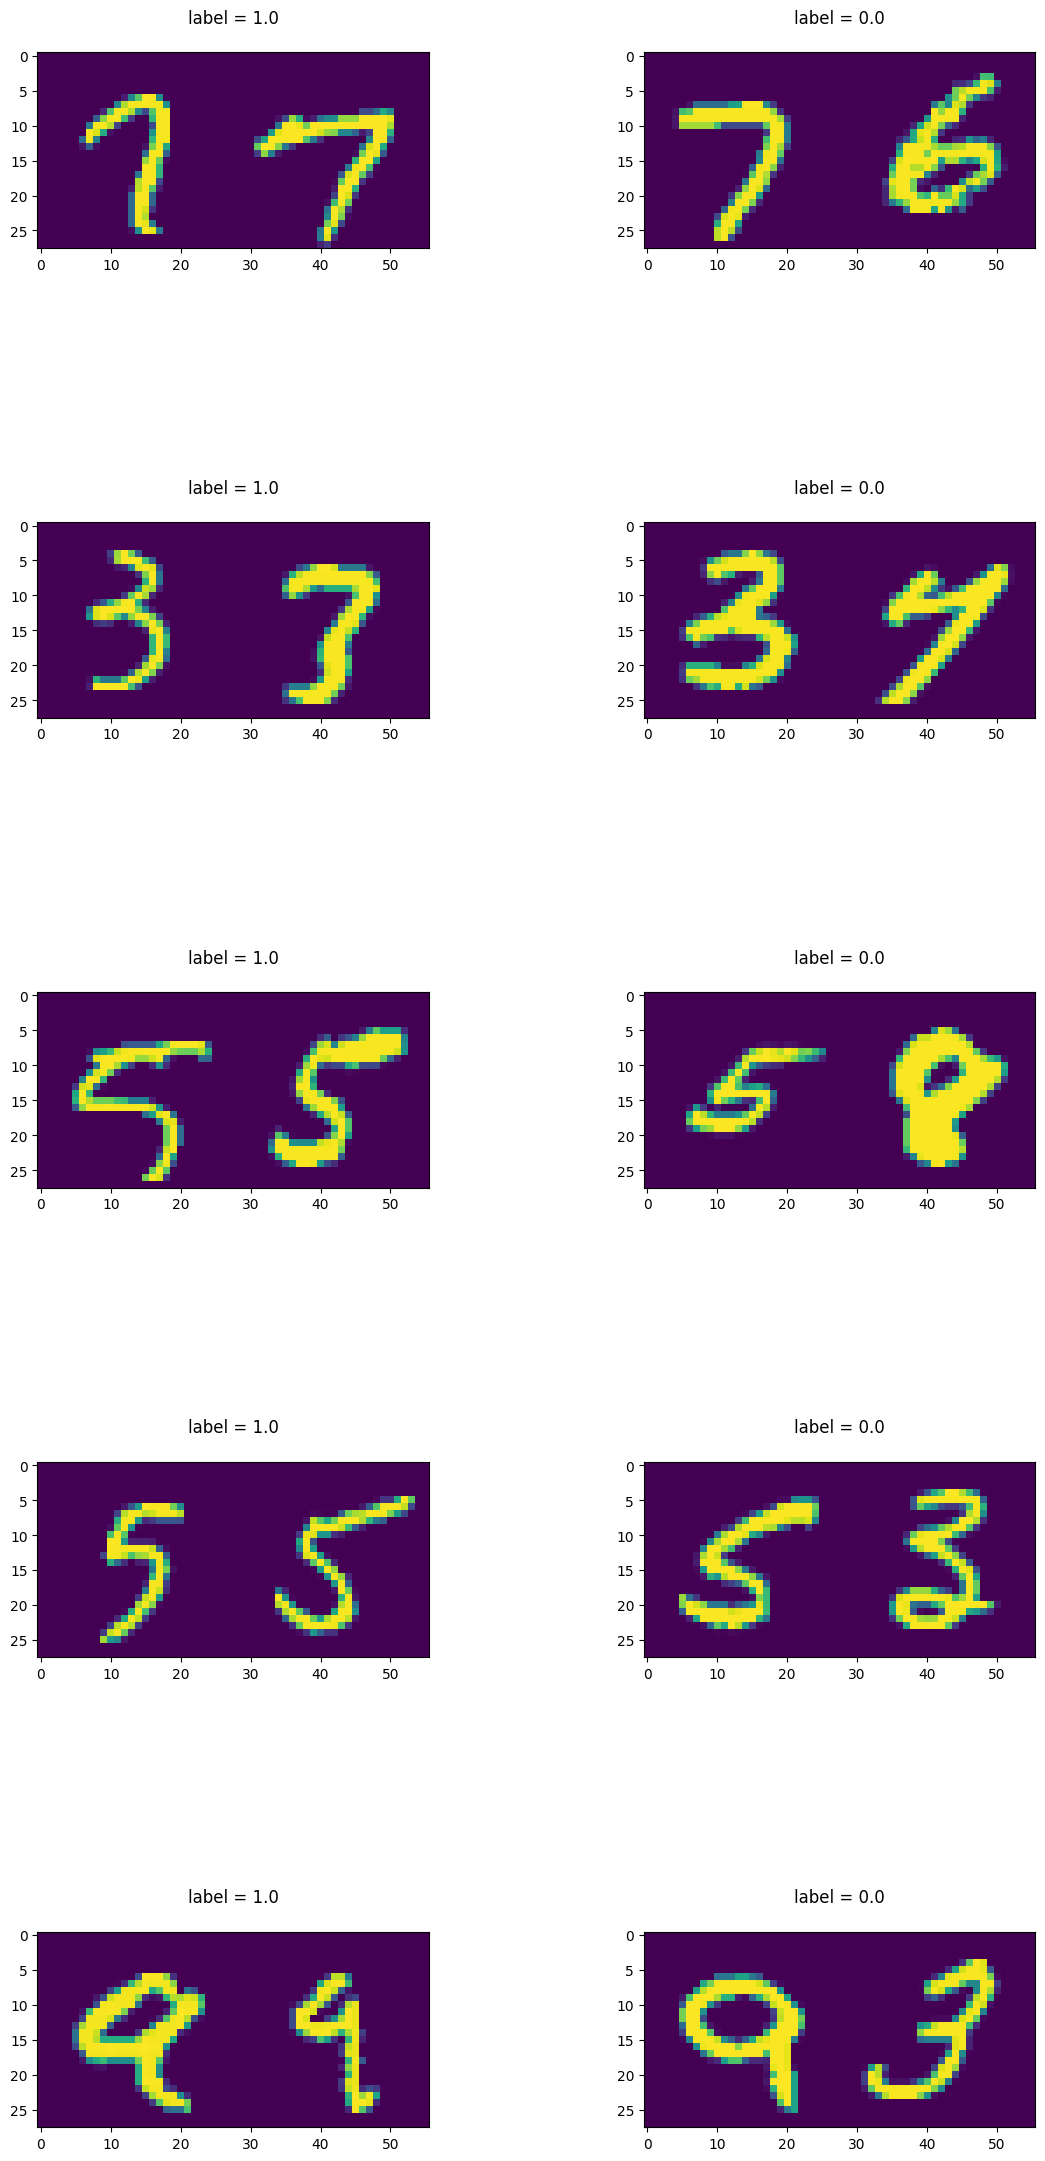

In [31]:
fig = plt.figure(1, figsize=(30,30))

i = 1 

for data in trial :

    im1, im2, lb1, im3, im4, lb2 = data

    diss1 = siam.evaluate(im1,im2)
    diss2 = siam.evaluate(im3,im4)
    
    im1 = np.concatenate((im1.numpy()[0],im2.numpy()[0]),axis=1)
    lb1 = lb1.numpy()
    
    im2 = np.concatenate((im3.numpy()[0],im4.numpy()[0]),axis=1)
    lb2 = lb2.numpy()
    
    diss1 = diss1.numpy()
    diss2 = diss2.numpy()

    ax1 = fig.add_subplot(10,4,i)
    ax1.title.set_text("label = "+str(lb1[0])+"\n")
    ax1.imshow(im1)
    
    ax2 = fig.add_subplot(10,4,i+1)
    ax2.title.set_text("label = "+str(lb2[0])+"\n")
    ax2.imshow(im2)

    i+=8


plt.show()   
fig.savefig("/content/Siamese-network-on-MNIST-PyTorch/Siamese/plot/Siamese_test.png")